In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes for those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients with prostate cancer (using the primary site code C619). Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation; and the control group, defined as the patients who did not receive any form of radiation. Operationally, these groups are defined by looking at the column RADIATN, which has values:

| Code	| Description |
|:---------:|:-------------:|
|0|	None; diagnosed at autopsy |
|1|	Beam radiation |
|2|	Radioacative implants |
|3|	Radioisotopes |
|4|	Combination of 1 with 2 or 3 |
|5|	Radiation, NOS - method or source not specified |
|6|	Other radiation (1973-1987 cases only) |
|7|	Patient or patient's guardian refused radiation therapy |
|8|	Radiation recommened, unknown if administered |
|9|	Unknown if radiation administered |

So that a value of 0 defines the control group, and teh values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [4]:
import seerhelp
malegenfiles = seerhelp.get_malegenfiles()
malegenfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\MALEGEN.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\MALEGEN.txt']

In [5]:
import seerhelp
malegenfiles = seerhelp.get_malegenfiles()


dfmalegen0 = seerhelp.make_clean_dataframe(malegenfiles[0])
dfmalegen1 = seerhelp.make_clean_dataframe(malegenfiles[1])
dfmalegen2 = seerhelp.make_clean_dataframe(malegenfiles[2])
dfmalegen3 = seerhelp.make_clean_dataframe(malegenfiles[3])

dfmalegen = pd.concat([dfmalegen0, dfmalegen1, dfmalegen2,
                     dfmalegen3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfmalegen.shape)

del dfmalegen0
del dfmalegen1
del dfmalegen2
del dfmalegen3

(1214943, 141)


In [6]:
dfmalegen.PRIMSITE.value_counts()

Prostate gland                                  1152617
Testis, NOS                                       32028
Descended testis                                  16107
Penis, NOS                                         6139
Glans penis                                        2526
Scrotum, NOS                                       1756
Prepuce                                            1346
Undescended testis                                  883
Body of penis                                       512
Spermatic cord                                      500
Overlapping lesion of penis                         267
Overlapping lesion of male genital organs            91
Male genital organs, NOS                             83
Epididymis                                           59
Other specified parts of male genital organs         29
Name: PRIMSITE, dtype: int64

In [8]:
dfprostateorig = dfmalegen[dfmalegen.PRIMSITE.str.contains('prostate',case=False)]
dfprostateorig.PRIMSITE.value_counts()

Prostate gland    1152617
Name: PRIMSITE, dtype: int64

In [10]:
mask = (dfprostateorig['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfprostateorig['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfprostateorig['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfprostateorig['CSTUMSIZ'] != "Not applicable") & \
(dfprostateorig['AGE_DX'] != "Unknown age") & \
(dfprostateorig['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfprostateorig['YEAR_DX'] >= 2004) & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfprostateorig['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfprostateorig['CSTUMSIZ'] != "Not applicable") & \
(dfprostateorig['YR_BRTH'] != 'Unknown year of birth') & \
(dfprostateorig['CSTUMSIZ'] != 'Not applicable') & \
(dfprostateorig['CSTUMSIZ'] != 996) & \
(dfprostateorig['CSTUMSIZ'] != 997) & \
(dfprostateorig['CSTUMSIZ'] != 998) & \
(dfprostateorig['REC_NO'] == 1) 

dfprostate = dfprostateorig[mask]



In [11]:
non_rad = dfprostate.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfprostate.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfprostate.RADIATN.str.contains('Unknown',case=False,na=False)

In [12]:
dfprostatecontrol = dfprostate[non_rad | refused_rad].copy()
dfprostatetreatment = dfprostate[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [13]:
print(dfprostatecontrol.shape, dfprostatetreatment.shape)


(51588, 141) (7261, 141)


## <font color='steelblue'>So we are going to match patients in the treatment group with their nearest neighbors in the control group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [14]:
dfprostatecontrol.set_index('PUBCSNUM', inplace=True)
dfprostatetreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfprostatecontrol.index
treatmentindices = dfprostatetreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfprostatecontrol, dfprostatetreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves</font>

In [15]:
resgoodcontrol = pd.concat([pd.get_dummies(dfprostatecontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfprostatetreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfprostatecontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfprostatecontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfprostatecontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfprostatecontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfprostatecontrol['lat']
resgoodcontrol['lng'] = dfprostatecontrol['lng']
resgoodcontrol['srv_time_mon'] = dfprostatecontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfprostatetreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfprostatetreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfprostatetreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfprostatetreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfprostatetreatment['lat']
resgoodtreatment['lng'] = dfprostatetreatment['lng']
resgoodtreatment['srv_time_mon'] = dfprostatetreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

## <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and trreatment groups together in pairs. 

In [16]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All left-sided breast');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 7261 observations, 6424 censored>

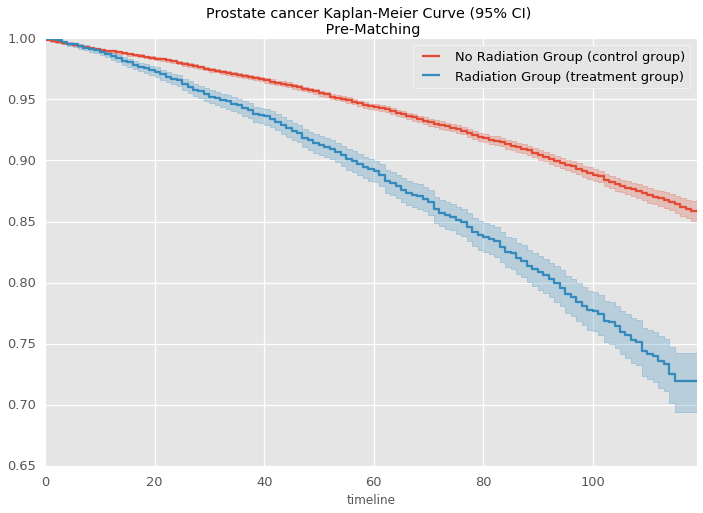

In [17]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Prostate cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");